In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Audio
import numpy as np
from scipy.signal import lfilter, butter, iirnotch
from scipy.io.wavfile import read
from scipy.fft import rfft, rfftfreq

In [ ]:
def get_glottal_wave(T, fs, duration):
  # T (sec) -  pitch period, fs (1/sec), duration (sec)
  Tp = int(0.4 * T * fs)
  Tn = int(0.16 * T * fs)
  Ts = int(T * fs)

  fp = [3 * (t / Tp) ** 2 - 2 * (t / Tp) ** 3 for t in range(Tp)]
  fn = [1 - ((t - Tp) / Tn) ** 2 for t in range(Tp, Tp + Tn)]
  f0 = [0 for t in range(Tp + Tn, Ts)]

  impulse = fp + fn + f0
  return impulse * int(duration / T)

In [ ]:
fs = 44100
f0 = 100

In [ ]:
src = get_glottal_wave(1/f0, fs, 0.2)

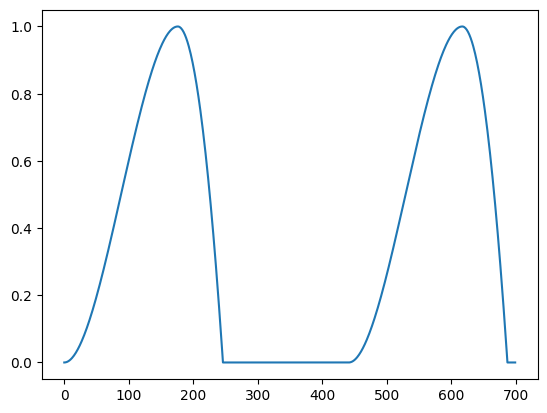

In [ ]:
plt.plot(src[:700])

In [ ]:
Audio(src, rate=fs)

In [ ]:
def plot_spectrum(sig, fs, xlim=10000, log=False):
  freqs = rfftfreq(len(sig), 1/fs)
  spectrum = np.log(np.abs(rfft(sig))) if log else np.abs(rfft(sig))
  plt.plot(freqs, spectrum)
  plt.grid()
  plt.xlim(0, xlim)

<ipython-input-9-a1501cf7d8a4>:3: RuntimeWarning: divide by zero encountered in log
  spectrum = np.log(np.abs(rfft(sig))) if log else np.abs(rfft(sig))


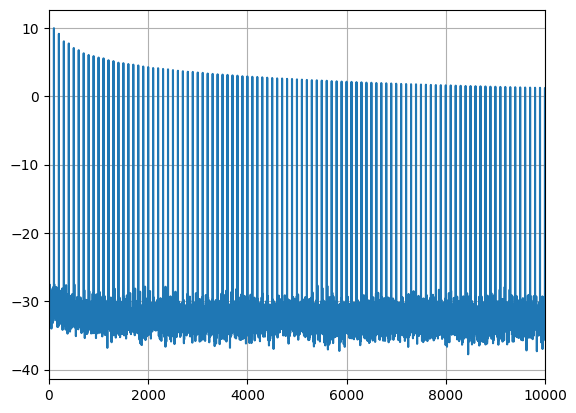

In [ ]:
plot_spectrum(src, fs, 10000, True)

In [ ]:
formants = {
    "a": [620,	1220,	2550,	3300,	4500],
    "a_m": [[620,	1220,	2550,	3300,	4500], 800],
    "o": [500, 800, 2500, 3200, 4300],
    "e": [550, 2000, 2600, 3450, 4700],
    "y": [450, 1400, 2300, 3400, 4500],
    "i": [300, 2200, 3000, 3700, 5000],
    "u": [300, 600, 2200, 3000, 4000],
    "w": [290, 610, 2150],
    "j": [260, 2070, 3020],
    "l": [310, 1050, 2880],
    "m": [[250, 1000, 2200], 800],
    "n": [[300, 1500, 3500], 1200],
    "ng": [[350, 1800, 2800], 1500],
}

In [ ]:
bandwidths = {
    "a": [80, 100, 140, 200, 250],
    "a_m": [[80, 100, 140, 200, 250], 150],
    "o": [70, 90, 110, 180, 230],
    "e": [80, 100, 130, 200, 250],
    "y": [70, 110, 120, 200, 250],
    "i": [60, 110, 130, 220, 270],
    "u": [50, 80, 100, 170, 220],
    "w": [50, 80, 60],
    "j": [40, 250, 500],
    "l": [50, 100, 280],
    "m": [[50, 80, 120],150],
    "n": [[60, 90, 130], 200],
    "ng": [[350, 1800, 2800], 200],
}

In [ ]:
def one_band_filter(sig, F, BW, fs):
  T = 1 / fs
  C = -np.exp(-2 * np.pi * BW * T)
  B = 2* np.exp(-np.pi * BW * T) * np.cos(2 * np.pi * F * T)
  A = 1 - B - C
  return lfilter([A], [1, -B, -C], sig)

In [ ]:
res_o = src
for freq, bw in zip(formants["o"], bandwidths["o"]):
  res_o = one_band_filter(res_o, freq, bw, fs)

In [ ]:
Audio(res_o, rate=fs)

In [ ]:
res_a = src
for freq, bw in zip(formants["a"], bandwidths["a"]):
  res_a = one_band_filter(res_a, freq, bw, fs)

In [ ]:
Audio(res_a, rate=fs)

In [ ]:
res_l = src
for freq, bw in zip(formants["l"], bandwidths["l"]):
  res_l = one_band_filter(res_l, freq, bw, fs)

res_j = src
for freq, bw in zip(formants["j"], bandwidths["j"]):
  res_j = one_band_filter(res_j, freq, bw, fs)

In [ ]:
laj = np.concatenate((
    res_l,
    res_a,
    res_j
))

In [ ]:
Audio(laj, rate=fs)

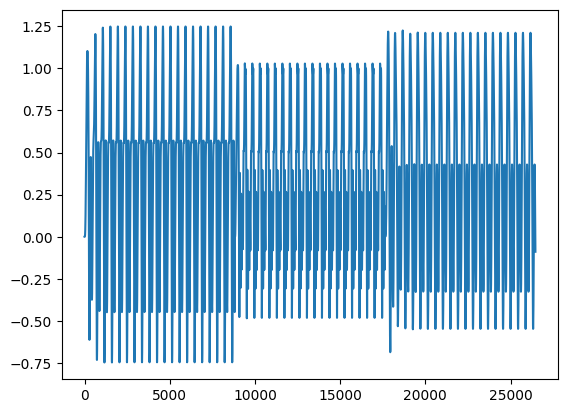

In [ ]:
plt.plot(laj)

In [ ]:
nasals = ('n', 'ng', 'm', 'a_m')

In [ ]:
def make_morph(phon_1, phon_2, periods_num, F0, fs):
  is_first_nasal = phon_1 in nasals
  is_second_nasal = phon_2 in nasals

  formants_ph_1 = formants[phon_1] if not is_first_nasal else formants[phon_1][0]
  formants_ph_2 = formants[phon_2] if not is_second_nasal else formants[phon_2][0]

  bw_phon_1 = bandwidths[phon_1] if not is_first_nasal else bandwidths[phon_1][0]
  bw_phon_2 = bandwidths[phon_2] if not is_second_nasal else bandwidths[phon_2][0]

  antif_1 = formants[phon_1][1] if is_first_nasal else []
  antif_2 = formants[phon_2][1] if is_second_nasal else []

  anti_bw_1 = bandwidths[phon_1][1] if is_first_nasal else []
  anti_bw_2 = bandwidths[phon_2][1] if is_second_nasal else []

  morph_formants = []
  morph_bws = []

  for i in range(periods_num):
    morph_formants.append([])
    morph_bws.append([])
    for j in range(min(len(formants_ph_1), len(formants_ph_2))):
      morph_formants[-1].append(formants_ph_1[j] + (i + 1)/(periods_num + 1) * (formants_ph_2[j] - formants_ph_1[j]))
      morph_bws[-1].append(bw_phon_1[j] + (i + 1)/(periods_num + 1) * (bw_phon_2[j] - bw_phon_1[j]))

  result = []

  for i in range(periods_num):
    duration = 1/F0
    source_per = get_glottal_wave(1/F0, fs, duration)
    res = source_per
    for f, bw in zip(morph_formants[i], morph_bws[i]):
      res = one_band_filter(res, f, bw, fs)

    result = np.concatenate((result, res))

  return result


In [ ]:
l_a = make_morph("l", "a", 5, 100, fs)
a_j = make_morph("a", "j", 5, 100, fs)

In [ ]:
laj = np.concatenate((
    res_l,
    l_a,
    res_a,
    a_j,
    res_j
))

In [ ]:
Audio(laj, rate=fs)

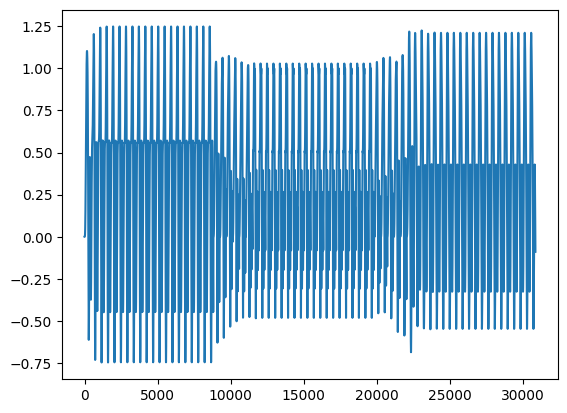

In [ ]:
plt.plot(laj)

In [ ]:
def get_sonorant(phon, F0, fs, duration, is_nasal=False):
  if not is_nasal:
    formants_ph = formants[phon]
    bandwidths_ph = bandwidths[phon]
  else:
    formants_ph = formants[phon][0]
    bandwidths_ph = bandwidths[phon][0]
    anti_f = formants[phon][1]
    anti_bw = bandwidths[phon][1]

  res = src
  for freq, bw in zip(formants_ph, bandwidths_ph):
    res = one_band_filter(res, freq, bw, fs)

  if is_nasal:
    b, a = iirnotch(anti_f, anti_bw, fs=fs)
    res = lfilter(b, a, res)

  return res

In [ ]:
ng_sound = get_sonorant("ng", 100, fs, 2, is_nasal=True)
n_sound = get_sonorant("n", 100, fs, 2, is_nasal=True)
m_sound = get_sonorant("m", 100, fs, 2, is_nasal=True)

In [ ]:
Audio(ng_sound, rate=fs)

In [ ]:
Audio(n_sound, rate=fs)

In [ ]:
Audio(m_sound, rate=fs)

In [ ]:
m_a = make_morph("m", "a", 5, 100, fs)
a_m = make_morph("a", "m", 5, 100, fs)
a_mm = get_sonorant("a_m", 100, fs, 2, is_nasal=True)

In [ ]:
mama = np.concatenate((
    m_sound,
    make_morph("m", "a", 5, 100, fs),
    a_mm,
    a_m,
    m_sound,
    m_a,
    0.3 * res_a
))

In [ ]:
Audio(mama, rate=fs)

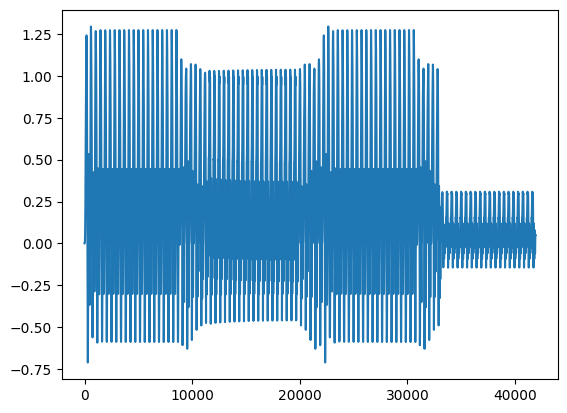

In [ ]:
plt.plot(mama)